In [1]:
!pip install opencv-python


[notice] A new release of pip is available: 23.1.2 -> 23.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
import os
import torch 
import torch.nn as nn 
import torch.optim as optim 
import torchvision.transforms as transforms 
import numpy as np 
import cv2
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm 
import matplotlib.pyplot as plt 
import random 

## 控制電腦中的亂數(保持每次訓練結果都一致)


In [3]:
def same_seeds(seed):
    random.seed(seed) 
    np.random.seed(seed)  
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

## 定義前處理方式

In [4]:
transform = transforms.Compose([
    transforms.ToTensor(), #轉換成張量
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # 正規化
])

## 轉換Label資料

In [5]:
label_encoding = {i:cnt for cnt, i in enumerate(os.listdir('Image/Train'))}
label_decoding = {v:k for k, v in label_encoding.items()}

## 讀取資料夾的圖片與標籤

In [6]:
x_train, y_train, x_valid, y_valid = [], [], [], []
for types in os.listdir('Image'):
    classes_path = f'Image/{types}'
    for classes in os.listdir(classes_path):
        file_path = f'{classes_path}/{classes}'
        for file_name in os.listdir(file_path):
            img = cv2.imread(f'{file_path}/{file_name}')
            if types  == 'Train':
                x_train.append(transform(img))
                y_train.append(label_encoding[classes])
            else:
                x_valid.append(transform(img))
                y_valid.append(label_encoding[classes])

## 資料轉型(List to Tensor)

In [7]:
x_train, x_valid = torch.stack(x_train, dim = 0), torch.stack(x_valid, dim = 0)
y_train, y_valid = torch.tensor(y_train), torch.tensor(y_valid)

## 建立 Dataset與Dataloader

In [8]:
class CIFAR10(Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
          
    def __getitem__(self, index):
        return self.x[index], self.y[index]
       
    def __len__(self):
        return len(self.x)
    
trainset = CIFAR10(x_train, y_train)
validset = CIFAR10(x_valid, y_valid)

train_loader = DataLoader(trainset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True)
valid_loader = DataLoader(validset, batch_size = 64, shuffle = True, num_workers = 0, pin_memory = True)

# 建立CNN模型

In [9]:
class CNN(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, 1, 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, 1, 1)
        self.fc1 = nn.Linear(4096, 128)
        self.fc2 = nn.Linear(128, 10)
        
        self.relu = nn.ReLU()
    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))
        x = self.pool(self.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        x = self.fc2(x)
        
        return x
    
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = CNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# 定義訓練的方式

In [10]:
def train(epoch):
    train_loss, train_acc = 0, 0
    train_pbar = tqdm(train_loader, position=0, leave=True) # 宣告進度條
    
    model.train() # 將模型切換成訓練模式
    for input_datas in train_pbar: 
        features, labels = [i.to(device) for i in input_datas] # 將資料放入到GPU中
        optimizer.zero_grad()  # 梯度清零
        outputs = model(features) # 模型計算答案(前向傳播)
        
        loss = criterion(outputs, labels) # 計算Loss值
        loss.backward() # 返向傳播
        optimizer.step() # 更新模型權重
        
        train_pbar.set_description(f'Train Epoch {epoch}')  # 顯示訓練次數
        train_pbar.set_postfix({'loss':f'{loss:.3f}'}) # 顯示當下模型損失
        
        _, pred = torch.max(outputs, dim = 1)  # 計算類別
        train_acc += sum(pred == labels) # 計算預測成功的數量
        train_loss += loss.item()  # 模型總損失

    return train_loss/len(train_loader), train_acc/len(trainset) # 計算一次訓練的Loss與準確率


def valid(epoch):
    valid_loss, valid_acc = 0, 0
    valid_pbar = tqdm(valid_loader, position=0, leave=True)
    
    model.eval()
    with torch.no_grad(): 
        for input_datas in valid_pbar:
            features, labels = [i.to(device) for i in input_datas]
            outputs = model(features) 
            loss = criterion(outputs, labels)

            valid_pbar.set_description(f'Valid Epoch {epoch}')
            valid_pbar.set_postfix({'loss':f'{loss:.3f}'})

            _, pred = torch.max(outputs, dim = 1) 
            valid_acc += sum(pred == labels)
            valid_loss += loss.item()

    return valid_loss/len(valid_loader), valid_acc/len(validset)

        
def show_training_loss(loss_record):
    train_loss, valid_loss = [i for i in loss_record.values()]
    
    plt.plot(train_loss)
    plt.plot(valid_loss)
    #標題
    plt.title('Result')
    #y軸標籤
    plt.ylabel('Loss')
    #x軸標籤
    plt.xlabel('Epoch')
    #顯示折線的名稱
    plt.legend(['train', 'valid'], loc='upper left')
    #顯示折線圖
    plt.show()

## 訓練模型

Valid Epoch 0: 100%|██████████| 157/157 [00:00<00:00, 190.27it/s, loss=1.138]


Saving Model With Acc 0.48800
Train Loss: 1.65106 Train Acc: 0.41610| Valid Loss: 1.43933 Valid Acc: 0.48800| Best Acc: 0.48800



Valid Epoch 1: 100%|██████████| 157/157 [00:01<00:00, 156.82it/s, loss=1.757]


Saving Model With Acc 0.54450
Train Loss: 1.34886 Train Acc: 0.52582| Valid Loss: 1.30384 Valid Acc: 0.54450| Best Acc: 0.54450



Valid Epoch 2: 100%|██████████| 157/157 [00:00<00:00, 186.32it/s, loss=1.211]


Saving Model With Acc 0.57290
Train Loss: 1.24240 Train Acc: 0.56432| Valid Loss: 1.20961 Valid Acc: 0.57290| Best Acc: 0.57290



Valid Epoch 3: 100%|██████████| 157/157 [00:00<00:00, 177.63it/s, loss=1.149]


Saving Model With Acc 0.59510
Train Loss: 1.16853 Train Acc: 0.59088| Valid Loss: 1.14568 Valid Acc: 0.59510| Best Acc: 0.59510



Valid Epoch 4: 100%|██████████| 157/157 [00:00<00:00, 184.51it/s, loss=1.271]


Saving Model With Acc 0.60230
Train Loss: 1.11035 Train Acc: 0.61284| Valid Loss: 1.12945 Valid Acc: 0.60230| Best Acc: 0.60230



Valid Epoch 5: 100%|██████████| 157/157 [00:00<00:00, 179.45it/s, loss=0.964]


Saving Model With Acc 0.62230
Train Loss: 1.06099 Train Acc: 0.63194| Valid Loss: 1.07193 Valid Acc: 0.62230| Best Acc: 0.62230



Valid Epoch 6: 100%|██████████| 157/157 [00:01<00:00, 147.43it/s, loss=0.831]


Saving Model With Acc 0.62950
Train Loss: 1.02009 Train Acc: 0.64534| Valid Loss: 1.04962 Valid Acc: 0.62950| Best Acc: 0.62950



Valid Epoch 7: 100%|██████████| 157/157 [00:00<00:00, 198.61it/s, loss=1.101]


Saving Model With Acc 0.63960
Train Loss: 0.98055 Train Acc: 0.66138| Valid Loss: 1.03516 Valid Acc: 0.63960| Best Acc: 0.63960



Valid Epoch 8: 100%|██████████| 157/157 [00:00<00:00, 189.94it/s, loss=0.505]


Saving Model With Acc 0.64870
Train Loss: 0.94967 Train Acc: 0.67000| Valid Loss: 1.00084 Valid Acc: 0.64870| Best Acc: 0.64870



Valid Epoch 9: 100%|██████████| 157/157 [00:00<00:00, 193.53it/s, loss=1.144]


Train Loss: 0.92138 Train Acc: 0.68156| Valid Loss: 1.00789 Valid Acc: 0.64230| Best Acc: 0.64870



Valid Epoch 10: 100%|██████████| 157/157 [00:00<00:00, 192.30it/s, loss=0.747]


Saving Model With Acc 0.66120
Train Loss: 0.89429 Train Acc: 0.69278| Valid Loss: 0.96783 Valid Acc: 0.66120| Best Acc: 0.66120



Valid Epoch 11: 100%|██████████| 157/157 [00:00<00:00, 199.00it/s, loss=0.856]


Saving Model With Acc 0.66750
Train Loss: 0.87214 Train Acc: 0.70018| Valid Loss: 0.95025 Valid Acc: 0.66750| Best Acc: 0.66750



Valid Epoch 12: 100%|██████████| 157/157 [00:00<00:00, 197.50it/s, loss=1.373]


Train Loss: 0.84733 Train Acc: 0.70810| Valid Loss: 0.95427 Valid Acc: 0.66710| Best Acc: 0.66750



Valid Epoch 13: 100%|██████████| 157/157 [00:00<00:00, 197.70it/s, loss=1.173]


Saving Model With Acc 0.66810
Train Loss: 0.82992 Train Acc: 0.71534| Valid Loss: 0.96046 Valid Acc: 0.66810| Best Acc: 0.66810



Valid Epoch 14: 100%|██████████| 157/157 [00:00<00:00, 193.68it/s, loss=0.522]


Saving Model With Acc 0.67980
Train Loss: 0.80983 Train Acc: 0.72242| Valid Loss: 0.92792 Valid Acc: 0.67980| Best Acc: 0.67980



Valid Epoch 15: 100%|██████████| 157/157 [00:00<00:00, 184.97it/s, loss=0.794]


Train Loss: 0.79123 Train Acc: 0.72748| Valid Loss: 0.94042 Valid Acc: 0.67760| Best Acc: 0.67980



Valid Epoch 16: 100%|██████████| 157/157 [00:00<00:00, 190.06it/s, loss=0.669]


Saving Model With Acc 0.68510
Train Loss: 0.77408 Train Acc: 0.73304| Valid Loss: 0.91191 Valid Acc: 0.68510| Best Acc: 0.68510



Valid Epoch 17: 100%|██████████| 157/157 [00:00<00:00, 184.40it/s, loss=0.993]


Train Loss: 0.75460 Train Acc: 0.74054| Valid Loss: 0.92233 Valid Acc: 0.68170| Best Acc: 0.68510



Valid Epoch 18: 100%|██████████| 157/157 [00:00<00:00, 162.38it/s, loss=0.748]


Train Loss: 0.74023 Train Acc: 0.74452| Valid Loss: 0.91162 Valid Acc: 0.68200| Best Acc: 0.68510



Valid Epoch 19: 100%|██████████| 157/157 [00:00<00:00, 157.27it/s, loss=1.079]


Saving Model With Acc 0.68800
Train Loss: 0.72641 Train Acc: 0.75106| Valid Loss: 0.90979 Valid Acc: 0.68800| Best Acc: 0.68800



Valid Epoch 20: 100%|██████████| 157/157 [00:00<00:00, 173.88it/s, loss=0.608]


Train Loss: 0.70852 Train Acc: 0.75592| Valid Loss: 0.91103 Valid Acc: 0.68610| Best Acc: 0.68800



Valid Epoch 21: 100%|██████████| 157/157 [00:00<00:00, 180.71it/s, loss=0.997]


Train Loss: 0.69511 Train Acc: 0.75912| Valid Loss: 0.91229 Valid Acc: 0.68530| Best Acc: 0.68800



Valid Epoch 22: 100%|██████████| 157/157 [00:00<00:00, 185.35it/s, loss=0.442]


Train Loss: 0.68072 Train Acc: 0.76550| Valid Loss: 0.93573 Valid Acc: 0.68160| Best Acc: 0.68800



Valid Epoch 23: 100%|██████████| 157/157 [00:00<00:00, 181.75it/s, loss=0.742]


Train Loss: 0.66961 Train Acc: 0.76984| Valid Loss: 0.91557 Valid Acc: 0.68630| Best Acc: 0.68800



Valid Epoch 24: 100%|██████████| 157/157 [00:00<00:00, 181.01it/s, loss=1.295]


Saving Model With Acc 0.69280
Train Loss: 0.65410 Train Acc: 0.77416| Valid Loss: 0.91541 Valid Acc: 0.69280| Best Acc: 0.69280



Valid Epoch 25: 100%|██████████| 157/157 [00:00<00:00, 179.72it/s, loss=1.491]


Saving Model With Acc 0.69380
Train Loss: 0.64338 Train Acc: 0.77836| Valid Loss: 0.92283 Valid Acc: 0.69380| Best Acc: 0.69380



Valid Epoch 26: 100%|██████████| 157/157 [00:00<00:00, 177.84it/s, loss=0.570]


Train Loss: 0.62929 Train Acc: 0.78436| Valid Loss: 0.93685 Valid Acc: 0.68710| Best Acc: 0.69380



Valid Epoch 27: 100%|██████████| 157/157 [00:00<00:00, 182.71it/s, loss=0.363]


Train Loss: 0.61944 Train Acc: 0.78832| Valid Loss: 0.90527 Valid Acc: 0.69340| Best Acc: 0.69380



Valid Epoch 28: 100%|██████████| 157/157 [00:00<00:00, 187.09it/s, loss=0.930]


Train Loss: 0.60718 Train Acc: 0.79166| Valid Loss: 0.91537 Valid Acc: 0.69020| Best Acc: 0.69380



Valid Epoch 29: 100%|██████████| 157/157 [00:00<00:00, 162.10it/s, loss=0.820]


Train Loss: 0.59752 Train Acc: 0.79462| Valid Loss: 0.92772 Valid Acc: 0.69070| Best Acc: 0.69380



Valid Epoch 30: 100%|██████████| 157/157 [00:00<00:00, 186.56it/s, loss=1.065]


Saving Model With Acc 0.69820
Train Loss: 0.58768 Train Acc: 0.79696| Valid Loss: 0.91880 Valid Acc: 0.69820| Best Acc: 0.69820



Valid Epoch 31: 100%|██████████| 157/157 [00:00<00:00, 171.64it/s, loss=1.505]


Train Loss: 0.57562 Train Acc: 0.80246| Valid Loss: 0.93307 Valid Acc: 0.69270| Best Acc: 0.69820



Valid Epoch 32: 100%|██████████| 157/157 [00:00<00:00, 189.08it/s, loss=1.844]


Train Loss: 0.56643 Train Acc: 0.80566| Valid Loss: 0.93255 Valid Acc: 0.69470| Best Acc: 0.69820



Valid Epoch 33: 100%|██████████| 157/157 [00:00<00:00, 176.51it/s, loss=1.860]


Train Loss: 0.55845 Train Acc: 0.80776| Valid Loss: 0.93694 Valid Acc: 0.69090| Best Acc: 0.69820



Valid Epoch 34: 100%|██████████| 157/157 [00:00<00:00, 167.66it/s, loss=1.104]


Train Loss: 0.54646 Train Acc: 0.81236| Valid Loss: 0.93049 Valid Acc: 0.69570| Best Acc: 0.69820



Valid Epoch 35: 100%|██████████| 157/157 [00:00<00:00, 197.88it/s, loss=0.842]


Train Loss: 0.53837 Train Acc: 0.81470| Valid Loss: 0.95445 Valid Acc: 0.68920| Best Acc: 0.69820



Valid Epoch 36: 100%|██████████| 157/157 [00:01<00:00, 152.37it/s, loss=0.575]


Train Loss: 0.52558 Train Acc: 0.81988| Valid Loss: 0.94636 Valid Acc: 0.69530| Best Acc: 0.69820



Valid Epoch 37: 100%|██████████| 157/157 [00:00<00:00, 190.72it/s, loss=0.695]


Train Loss: 0.51746 Train Acc: 0.82162| Valid Loss: 0.97119 Valid Acc: 0.68860| Best Acc: 0.69820



Valid Epoch 38: 100%|██████████| 157/157 [00:00<00:00, 171.52it/s, loss=1.318]


Train Loss: 0.51166 Train Acc: 0.82442| Valid Loss: 0.97532 Valid Acc: 0.69080| Best Acc: 0.69820



Valid Epoch 39: 100%|██████████| 157/157 [00:00<00:00, 189.76it/s, loss=0.958]


Train Loss: 0.50243 Train Acc: 0.82816| Valid Loss: 0.97090 Valid Acc: 0.68560| Best Acc: 0.69820



Valid Epoch 40: 100%|██████████| 157/157 [00:00<00:00, 183.01it/s, loss=0.832]


------------------------------------
|Model can't improve, stop training|
------------------------------------


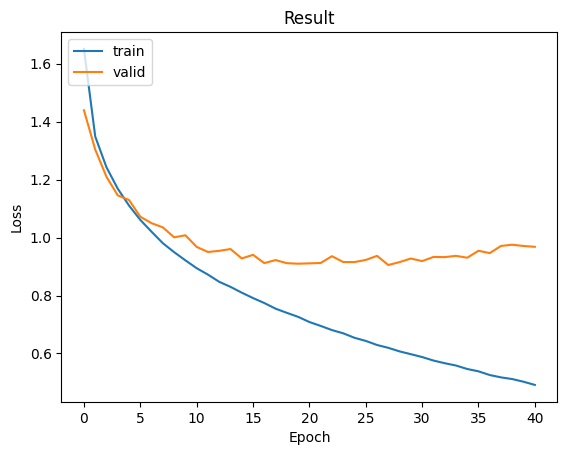

In [11]:
epochs = 50                              # 訓練次數
early_stopping = 10                      # 模型訓練幾次沒進步就停止
stop_cnt = 0                             # 計數模型是否有進步的計數器
model_path = 'model.ckpt'                # 模型存放路徑
show_loss = True                         # 是否顯示訓練折線圖
best_acc = 0                             # 最佳的準確率
loss_record = {'train':[], 'valid':[]}   # 訓練紀錄

for epoch in range(epochs):   
    train_loss, train_acc = train(epoch)
    valid_loss, valid_acc = valid(epoch)
    
    loss_record['train'].append(train_loss)
    loss_record['valid'].append(valid_loss)
    
    # 儲存最佳的模型權重
    if valid_acc > best_acc:
        best_acc = valid_acc
        torch.save(model.state_dict(), model_path)
        print(f'Saving Model With Acc {best_acc:.5f}')
        stop_cnt = 0
    else:
        stop_cnt+=1
    
    # Early stopping
    if stop_cnt == early_stopping:
        output = "Model can't improve, stop training"
        print('-' * (len(output)+2))
        print(f'|{output}|')
        print('-' * (len(output)+2))
        break
        
    print(f'Train Loss: {train_loss:.5f} Train Acc: {train_acc:.5f}', end='| ')
    print(f'Valid Loss: {valid_loss:.5f} Valid Acc: {valid_acc:.5f}', end='| ')
    print(f'Best Acc: {best_acc:.5f}', end ='\n\n')

if show_loss:
    show_training_loss(loss_record)
        

## 讀取歷史最佳模型

In [12]:
mdoel = CNN()
model.load_state_dict(torch.load(model_path))
model.eval()

CNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (fc1): Linear(in_features=4096, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
  (relu): ReLU()
)

## 實際預測方式

Label: Airplane


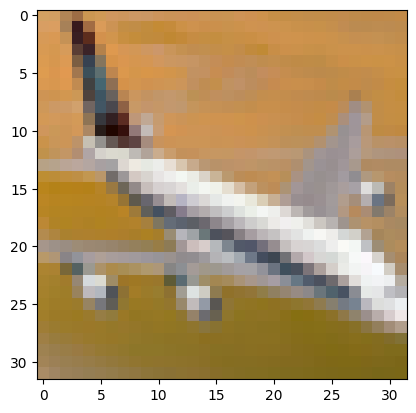

In [14]:
img = x_valid[90].unsqueeze(0).to(device)    # 將圖片新增維度

output = model(img)                          # 計算各類別機率
_, pred = torch.max(output, dim = 1)         # 找到最大機率的位子

label = pred.tolist()[0]                     # 取得Label
npimg = (x_valid[90]/2+0.5).numpy()          # 還原正規化
npimg = np.transpose(npimg, (1, 2, 0))       # 維度還原

plt.imshow(npimg)                            # 顯示圖片
print('Label:',label_decoding[label])        # 顯示文字 